<a href="https://colab.research.google.com/github/tharushaliyanagama/OralCancerEarlyDetection-DSGP/blob/Prediction-of-textual-data-I/Patient_Risk_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib
from keras.models import Sequential
from keras.layers import Dense
import shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load The Dataset
data=pd.read_csv("/content/drive/MyDrive/DSGP/Siyumi/Modelnew/new/preprocessed_new_dataset.csv")

In [ ]:
data.head()

,Age,Gender_Female,Gender_Male,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_South America,Socioeconomic_Status_High,Socioeconomic_Status_Low,Socioeconomic_Status_Middle,Tobacco_Use_No,Tobacco_Use_Yes,Alcohol_Use_No,Alcohol_Use_Yes,HPV_Related_No,HPV_Related_Yes
0,-0.854669,False,True,True,False,False,False,False,True,False,False,False,True,False,True,True,False
1,1.563365,True,False,False,False,True,False,False,True,False,False,False,True,False,True,True,False
2,0.499430,True,False,False,False,True,False,False,False,False,True,False,True,False,True,False,True
3,-0.177619,False,True,True,False,False,False,False,False,False,True,False,True,False,True,True,False
4,-1.241555,False,True,False,False,True,False,False,False,False,True,False,True,False,True,True,False


In [ ]:
data.shape

(64653, 17)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64653 entries, 0 to 64652
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          64653 non-null  float64
 1   Gender_Female                64653 non-null  bool   
 2   Gender_Male                  64653 non-null  bool   
 3   Continent_Africa             64653 non-null  bool   
 4   Continent_Asia               64653 non-null  bool   
 5   Continent_Europe             64653 non-null  bool   
 6   Continent_North America      64653 non-null  bool   
 7   Continent_South America      64653 non-null  bool   
 8   Socioeconomic_Status_High    64653 non-null  bool   
 9   Socioeconomic_Status_Low     64653 non-null  bool   
 10  Socioeconomic_Status_Middle  64653 non-null  bool   
 11  Tobacco_Use_No               64653 non-null  bool   
 12  Tobacco_Use_Yes              64653 non-null  bool   
 13  Alcohol_Use_No  

In [ ]:
#Feature selection for clustering
features = ['Gender_Male','Gender_Female', 'Tobacco_Use_Yes', 'Alcohol_Use_Yes','Tobacco_Use_No', 'Alcohol_Use_No','Socioeconomic_Status_High','Socioeconomic_Status_Middle','Socioeconomic_Status_Low' ,'HPV_Related_Yes','HPV_Related_No']
X = data[features]

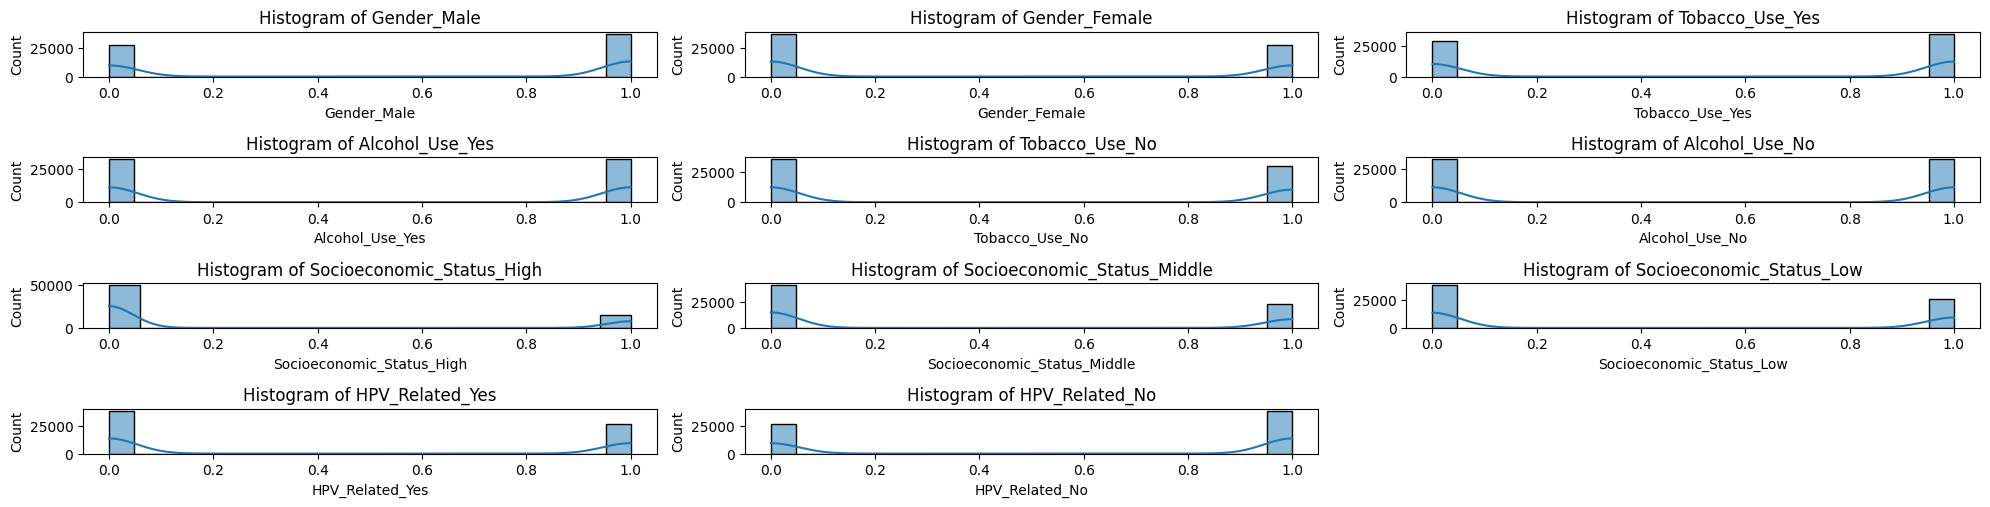

In [ ]:
# Plot histogram for each feature
plt.figure(figsize=(20,6))

for i, feature in enumerate(features, 1):
    plt.subplot(5, 3, i)
    sns.histplot(data[feature], kde=True)
    plt.title(f'Histogram of {feature}')

plt.tight_layout()
plt.show()

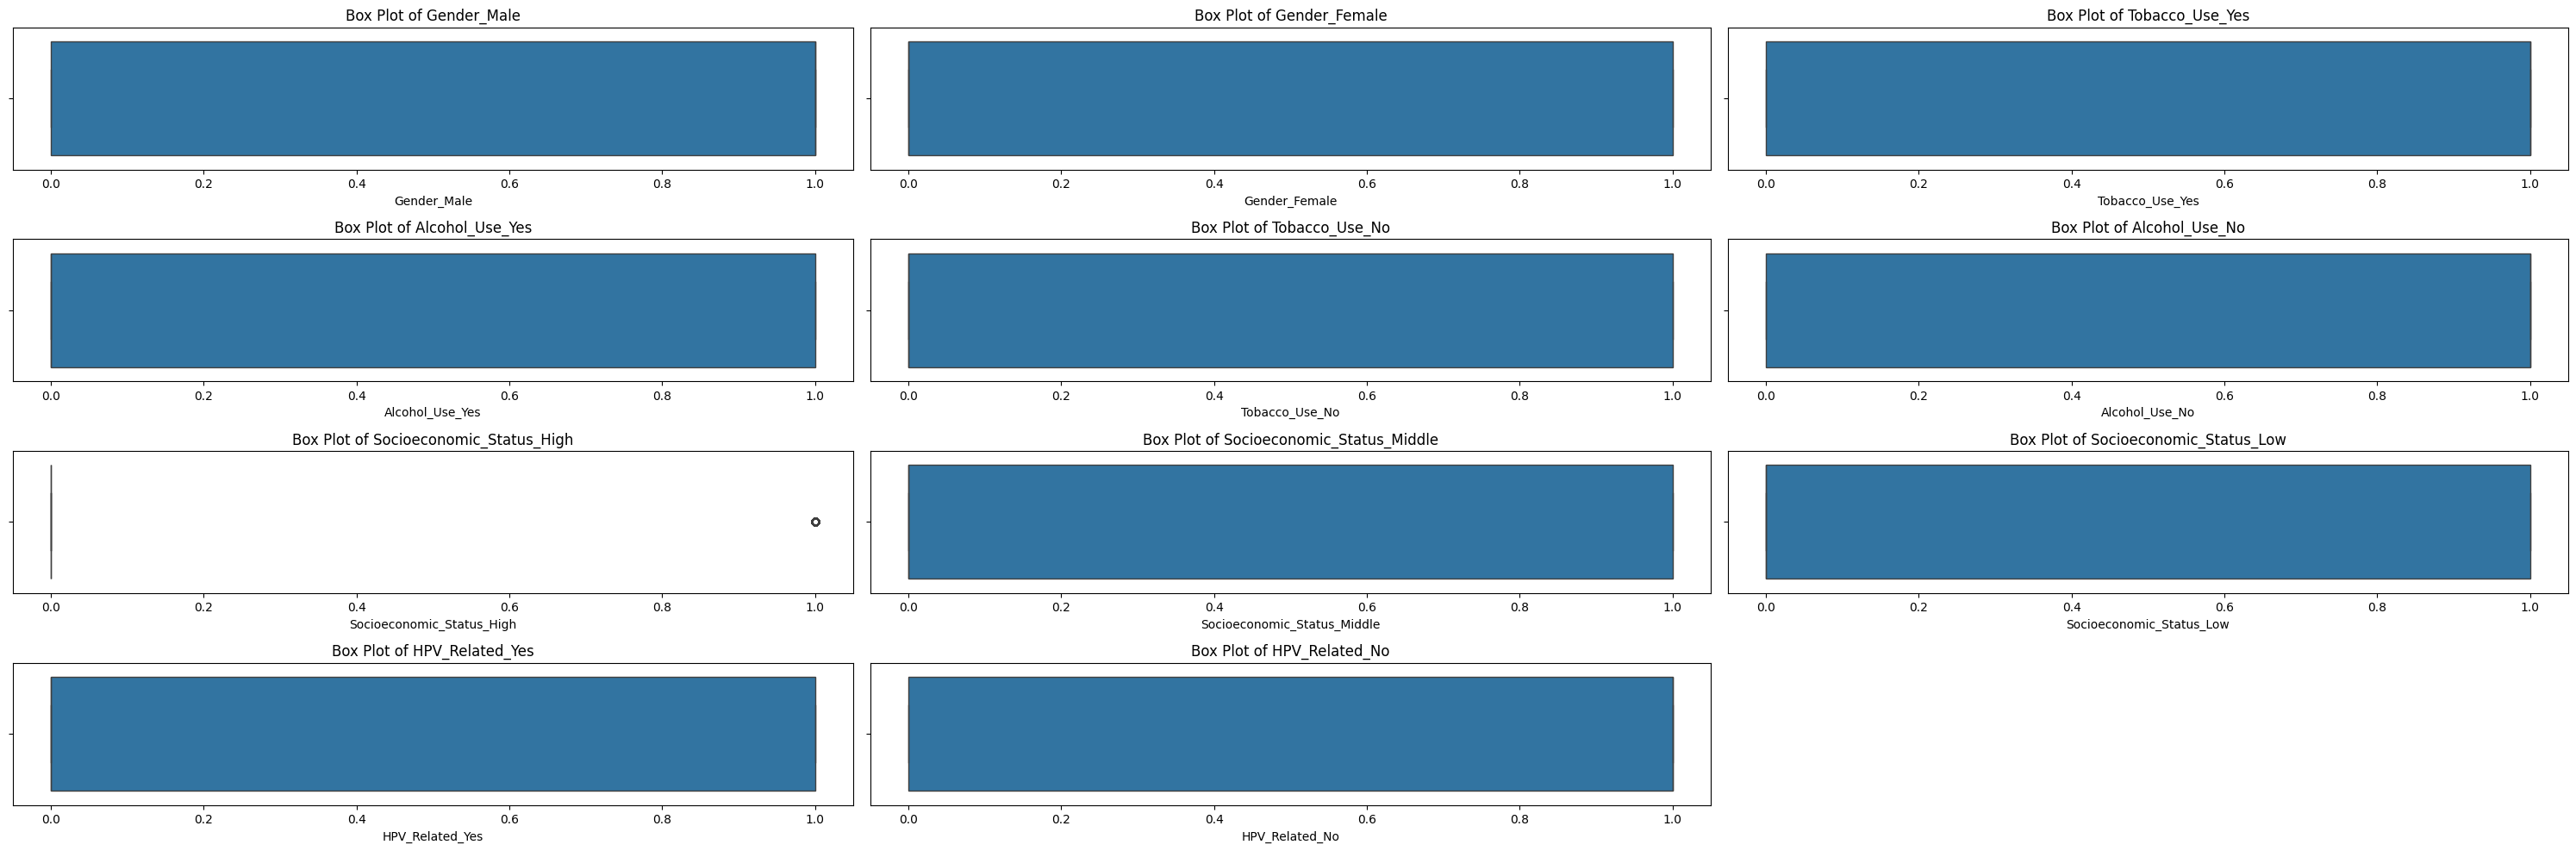

In [ ]:
# Box plot for features
plt.figure(figsize=(30,12))

for i, feature in enumerate(features, 1):
    plt.subplot(5, 3, i)
    sns.boxplot(x=data[feature])
    plt.title(f'Box Plot of {feature}')

plt.tight_layout()
plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

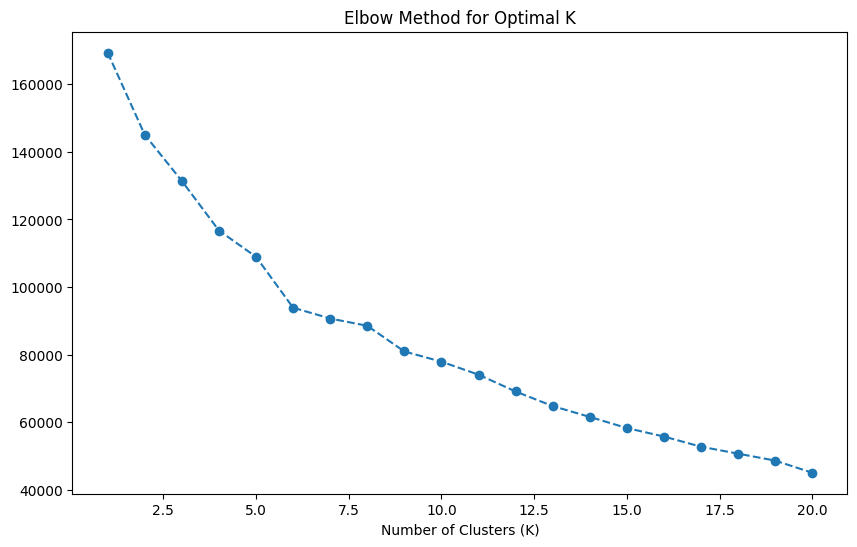

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []

for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data[features])
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=42, max_iter=1000)
kmeans.fit_predict(data[features])

data['Cluster'] = kmeans.labels_

In [ ]:
print(data["Cluster"].value_counts())

Cluster
3    13178
2    12211
1    11274
0    10978
5    10885
4     6127
Name: count, dtype: int64


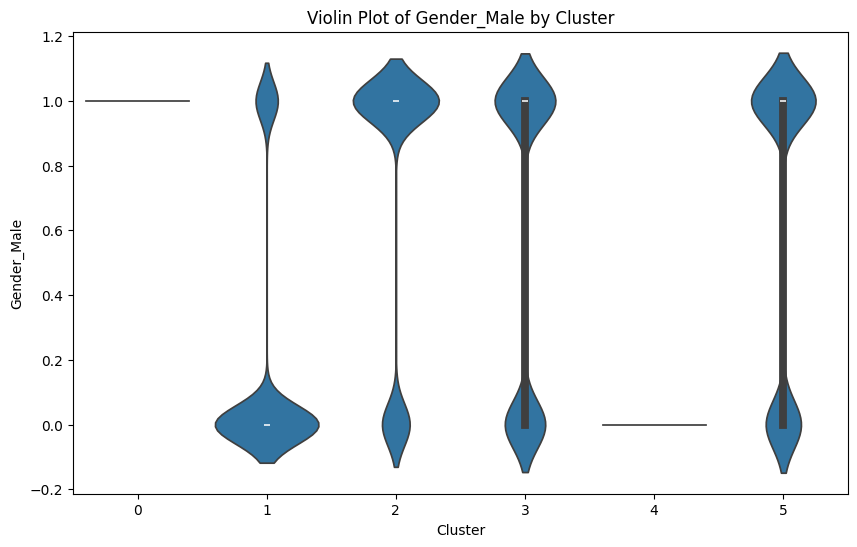

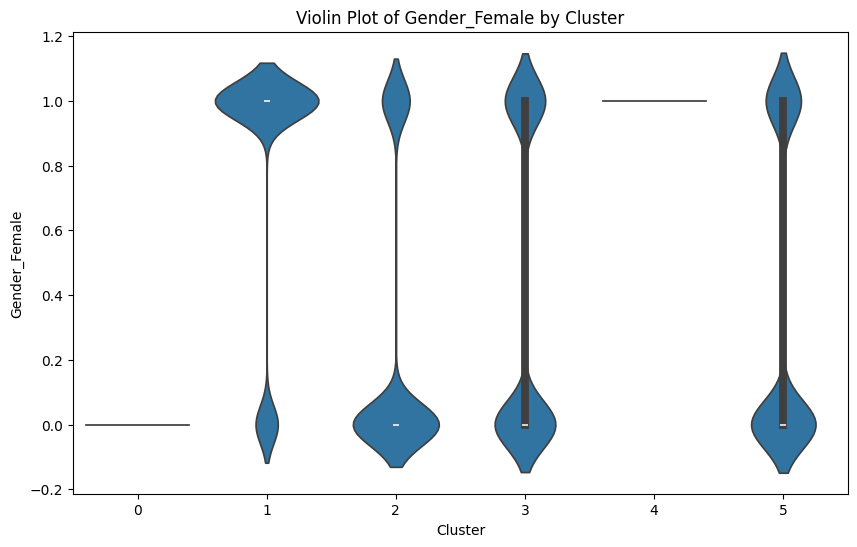

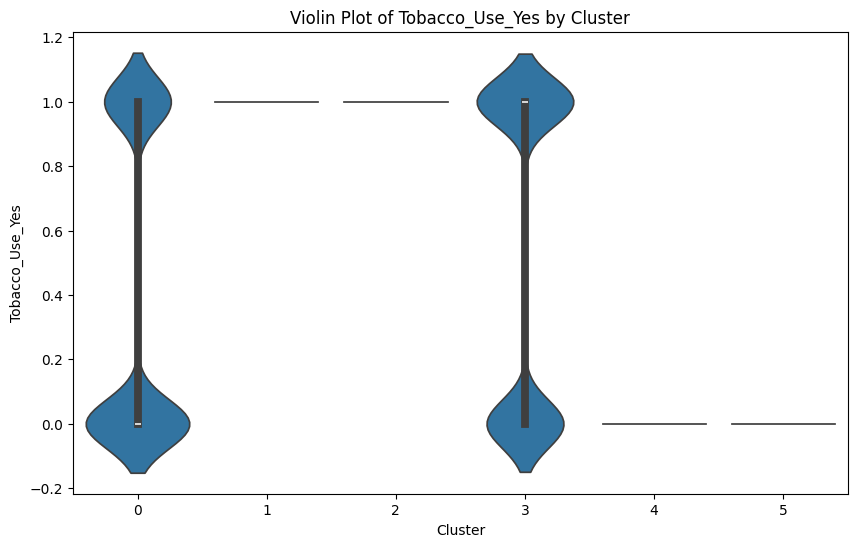

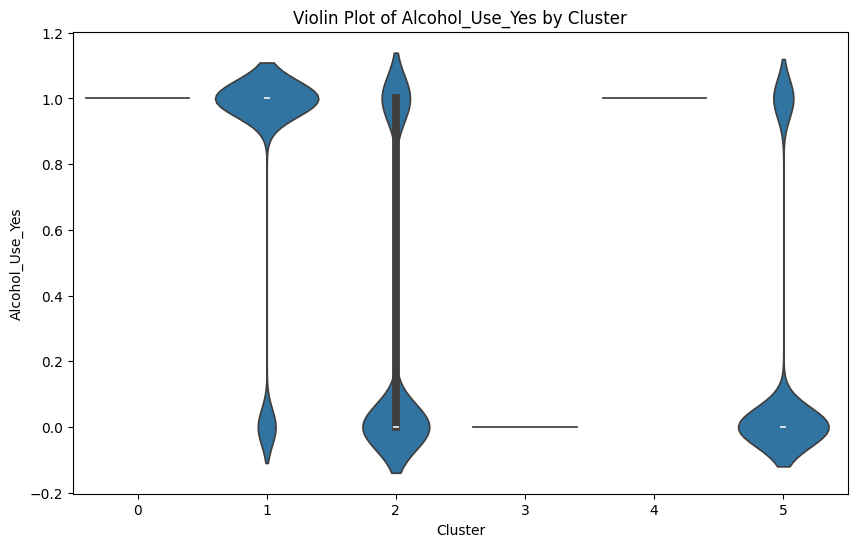

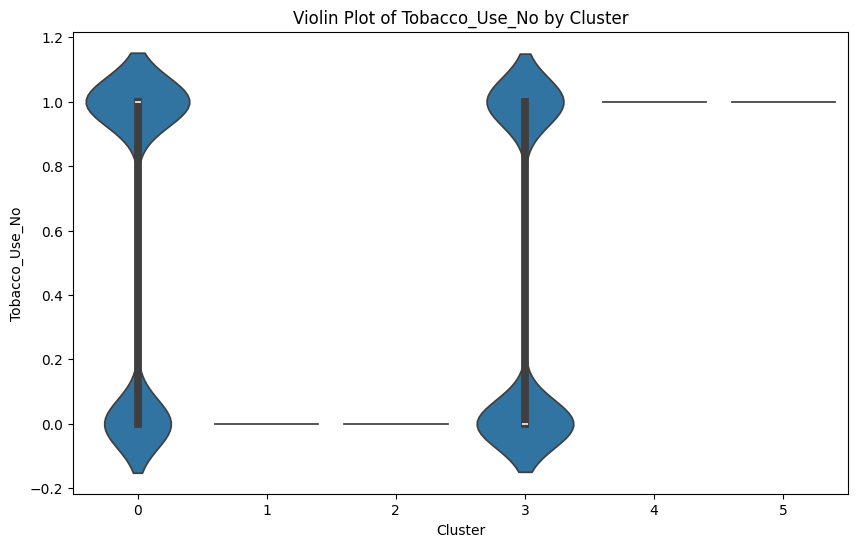

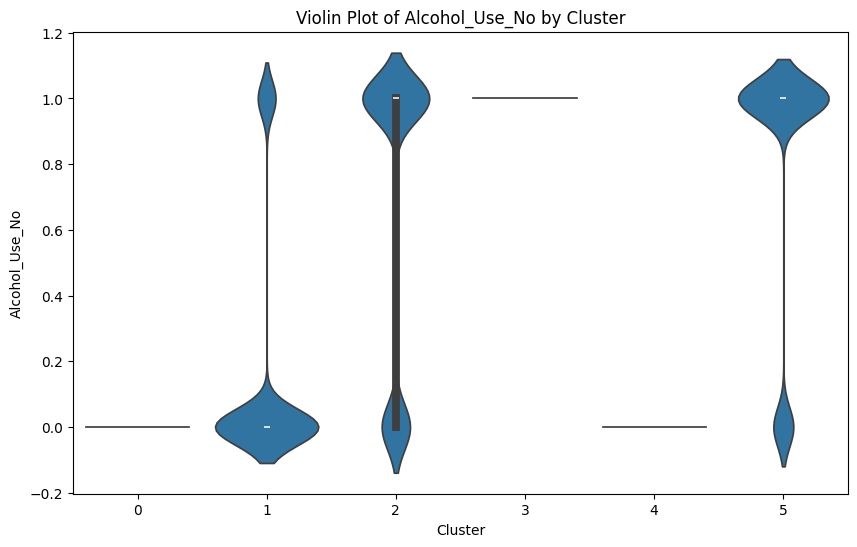

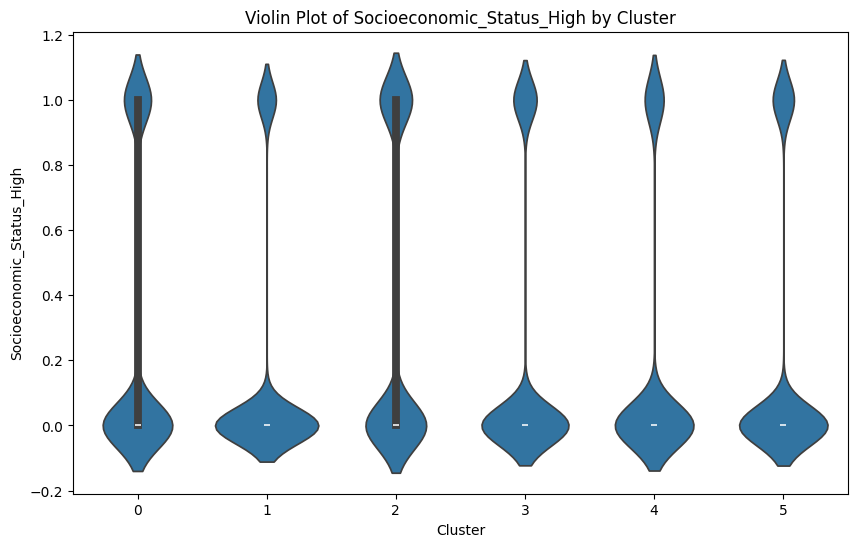

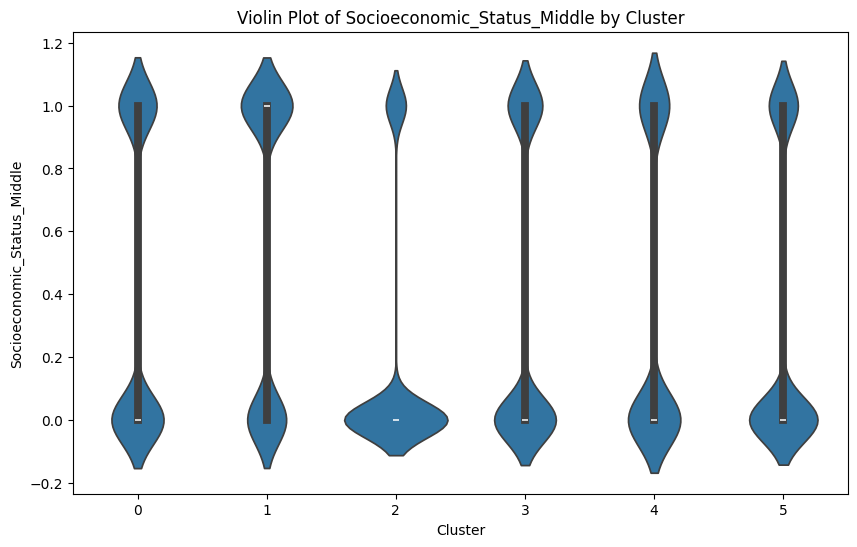

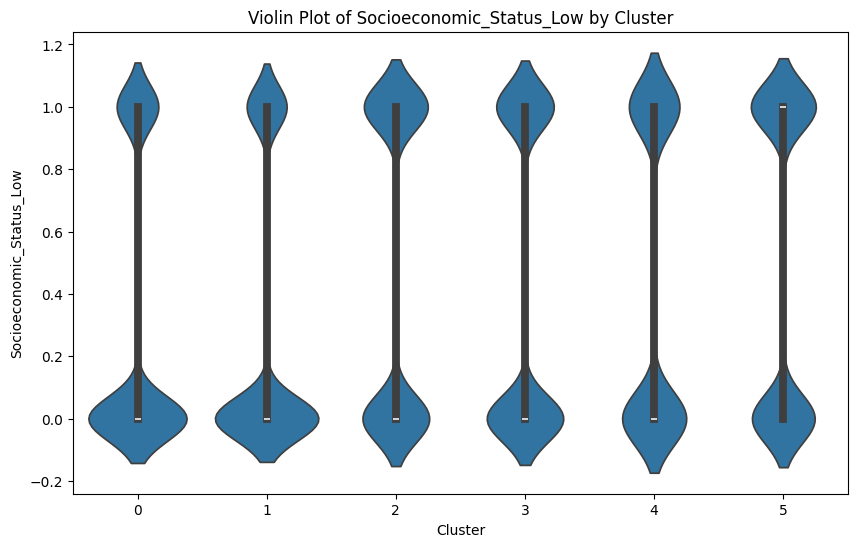

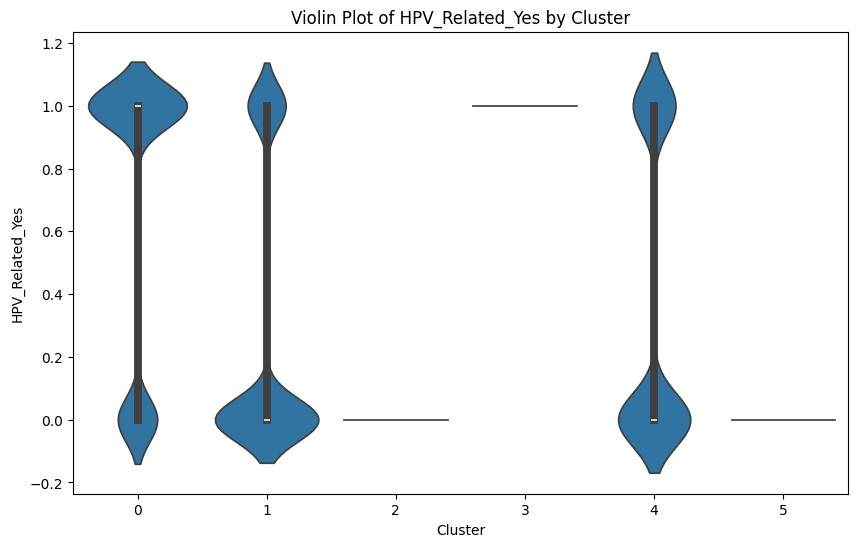

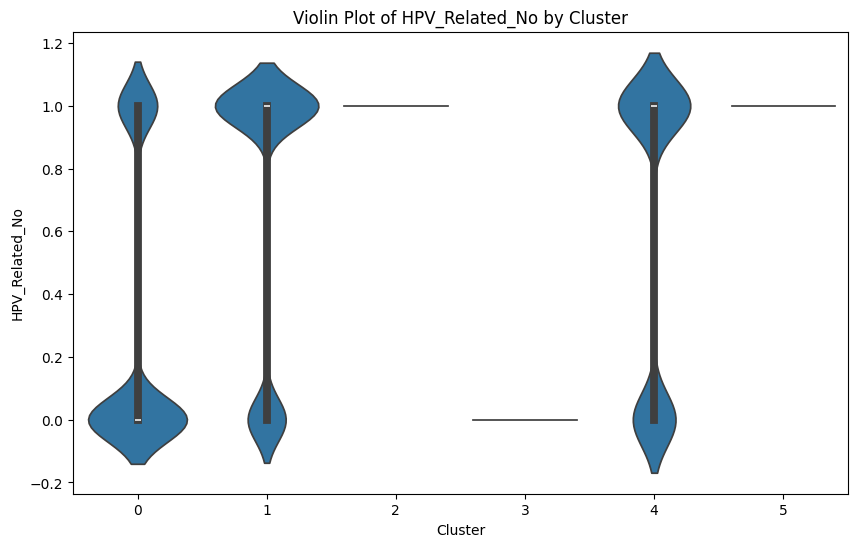

In [ ]:
# Display violin plot
data["Cluster"] = kmeans.labels_

features = ['Gender_Male','Gender_Female', 'Tobacco_Use_Yes', 'Alcohol_Use_Yes','Tobacco_Use_No', 'Alcohol_Use_No','Socioeconomic_Status_High','Socioeconomic_Status_Middle','Socioeconomic_Status_Low' ,'HPV_Related_Yes','HPV_Related_No']

for feature in features:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Cluster', y=feature, data=data)
    plt.title(f'Violin Plot of {feature} by Cluster')
    plt.xlabel('Cluster')

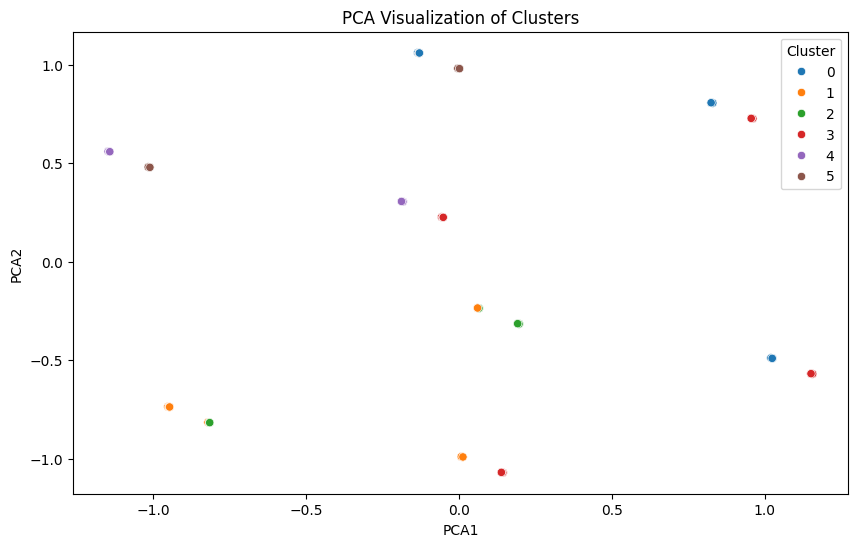

In [ ]:
# Visualize with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
data["PCA1"] = X_pca[:, 0]
data["PCA2"] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue="Cluster", data=data, palette="tab10")
plt.title('PCA Visualization of Clusters')
plt.show()

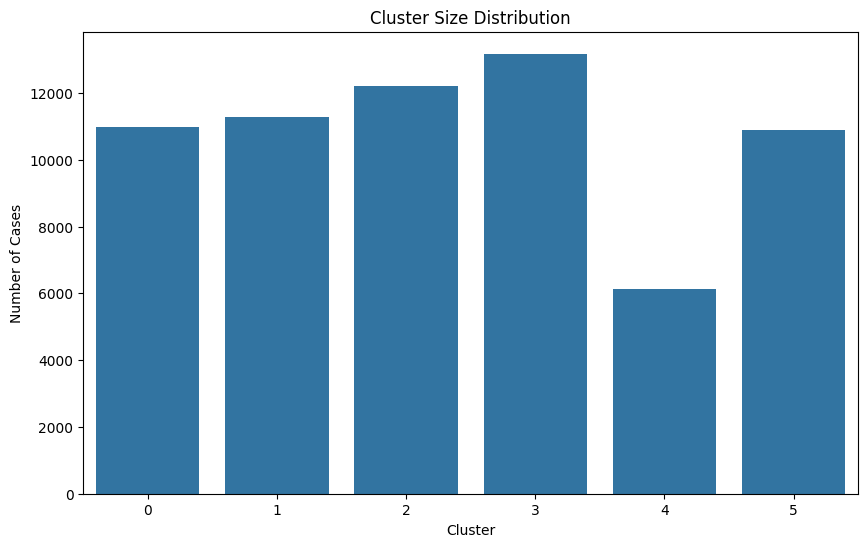

In [ ]:
# Count the number of cases per cluster
cluster_counts = data['Cluster'].value_counts()

# Bar chart of cluster sizes
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Cases')
plt.title('Cluster Size Distribution')
plt.show()

,Gender_Male,Gender_Female,Tobacco_Use_Yes,Alcohol_Use_Yes,Tobacco_Use_No,Alcohol_Use_No,Socioeconomic_Status_High,Socioeconomic_Status_Middle,Socioeconomic_Status_Low,HPV_Related_Yes,HPV_Related_No
Cluster,,,,,,,,,,,
0,0.000000,0.000000,0.238271,0.000000,0.238271,0.000000,0.201504,0.243999,0.209162,0.203882,0.203882
1,0.145311,0.145311,0.000000,0.125134,0.000000,0.125134,0.128435,0.245161,0.201159,0.196545,0.196545
2,0.184207,0.184207,0.000000,0.208985,0.000000,0.208985,0.226904,0.136255,0.249906,0.000000,0.000000
3,0.239924,0.239924,0.246788,0.000000,0.246788,0.000000,0.166423,0.230373,0.245017,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.156526,0.231709,0.246578,0.233560,0.233560
5,0.228536,0.228536,0.000000,0.147890,0.000000,0.147890,0.156058,0.209188,0.249949,0.000000,0.000000


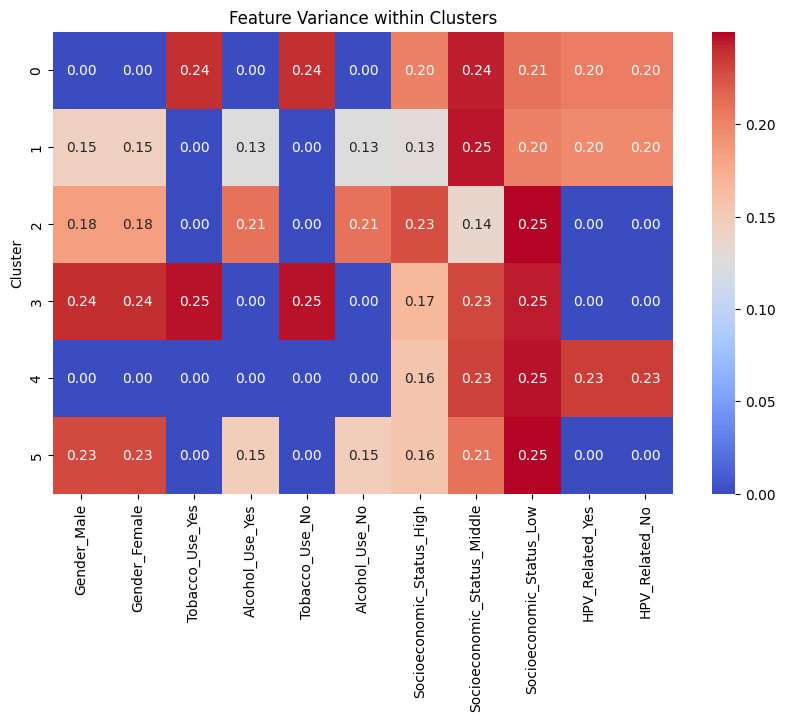

In [ ]:
# import seaborn
import seaborn as sns

# Calculate feature variance within clusters
cluster_variance = data.groupby('Cluster')[features].var()
display(cluster_variance)

# Visualize feature variance across clusters
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_variance, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Variance within Clusters')
plt.show()

In [ ]:
# Define cluster-to-risk mapping
cluster_risk_mapping = {
    0: "Medium Risk",
    1: "High Risk",
    2: "Low Risk",
    3: "High Risk",
    4: "Low Risk",
    5: "Medium Risk"
}

# Assuming 'Cluster' column already exists in the dataset after clustering
data["Risk_Level"] = data["Cluster"].map(cluster_risk_mapping)

In [ ]:
data.head(10)

,Age,Gender_Female,Gender_Male,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_South America,Socioeconomic_Status_High,Socioeconomic_Status_Low,...,Tobacco_Use_No,Tobacco_Use_Yes,Alcohol_Use_No,Alcohol_Use_Yes,HPV_Related_No,HPV_Related_Yes,Cluster,PCA1,PCA2,Risk_Level
0,-0.854669,False,True,True,False,False,False,False,True,False,...,False,True,False,True,True,False,2,0.066085,-0.235909,Low Risk
1,1.563365,True,False,False,False,True,False,False,True,False,...,False,True,False,True,True,False,1,-0.946190,-0.736822,High Risk
2,0.499430,True,False,False,False,True,False,False,False,False,...,False,True,False,True,False,True,1,0.007440,-0.989193,High Risk
3,-0.177619,False,True,True,False,False,False,False,False,False,...,False,True,False,True,True,False,1,0.060628,-0.234563,High Risk
4,-1.241555,False,True,False,False,True,False,False,False,False,...,False,True,False,True,True,False,1,0.060628,-0.234563,High Risk
5,-1.241555,False,True,False,True,False,False,False,True,False,...,False,True,True,False,True,False,2,0.197199,-0.315364,Low Risk
6,-1.434997,True,False,False,False,False,False,True,False,True,...,False,True,False,True,True,False,1,-0.947370,-0.737356,High Risk
7,1.176480,True,False,False,True,False,False,False,False,True,...,False,True,False,True,False,True,1,0.011717,-0.991073,High Risk
8,-0.129259,True,False,True,False,False,False,False,False,True,...,True,False,True,False,True,False,5,-1.011773,0.478718,Medium Risk
9,0.402709,True,False,False,False,False,False,True,False,False,...,True,False,False,True,True,False,4,-1.147164,0.560054,Low Risk


In [ ]:
#drop cluster, PCA1, PCA2
data = data.drop(['Cluster','PCA1','PCA2'], axis=1) # Pass labels as a list and specify axis

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64653 entries, 0 to 64652
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          64653 non-null  float64
 1   Gender_Female                64653 non-null  bool   
 2   Gender_Male                  64653 non-null  bool   
 3   Continent_Africa             64653 non-null  bool   
 4   Continent_Asia               64653 non-null  bool   
 5   Continent_Europe             64653 non-null  bool   
 6   Continent_North America      64653 non-null  bool   
 7   Continent_South America      64653 non-null  bool   
 8   Socioeconomic_Status_High    64653 non-null  bool   
 9   Socioeconomic_Status_Low     64653 non-null  bool   
 10  Socioeconomic_Status_Middle  64653 non-null  bool   
 11  Tobacco_Use_No               64653 non-null  bool   
 12  Tobacco_Use_Yes              64653 non-null  bool   
 13  Alcohol_Use_No  

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the correct directory and filename
folder_path = "/content/drive/MyDrive/DSGP/Siyumi/Modelnew/new"
file_name = "new_target_dataset.csv"
full_path = os.path.join(folder_path, file_name)

# Ensure the folder exists
os.makedirs(folder_path, exist_ok=True)

# Save the dataset
data.to_csv(full_path, index=False)

print(f"Preprocessed dataset saved to: {full_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Preprocessed dataset saved to: /content/drive/MyDrive/DSGP/Siyumi/Modelnew/new/new_target_dataset.csv


In [ ]:
data.shape

(64653, 17)

In [ ]:
# Label encode the risk level
label_encoder = LabelEncoder()
data['Risk_Level'] = label_encoder.fit_transform(data['Risk_Level'])

In [ ]:
# Risk level value count
data['Risk_Level'].value_counts()

,count
Risk_Level,
2,61912
1,50191
0,48189


In [ ]:
data.head(10)

,Age,Gender_Female,Gender_Male,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_South America,Socioeconomic_Status_High,Socioeconomic_Status_Low,Socioeconomic_Status_Middle,Tobacco_Use_No,Tobacco_Use_Yes,Alcohol_Use_No,Alcohol_Use_Yes,HPV_Related_No,HPV_Related_Yes,Risk_Level
0,-0.610075,False,True,True,False,False,False,False,True,False,False,False,True,False,True,True,False,2
1,1.817774,True,False,False,False,True,False,False,True,False,False,False,True,False,True,True,False,2
2,0.749520,True,False,False,False,True,False,False,False,False,True,False,True,False,True,False,True,2
3,0.069723,False,True,True,False,False,False,False,False,False,True,False,True,False,True,True,False,0
4,-0.998530,False,True,False,False,True,False,False,False,False,True,False,True,False,True,True,False,0
5,-0.998530,False,True,False,True,False,False,False,True,False,False,False,True,True,False,True,False,2
6,-1.192758,True,False,False,False,False,False,True,False,True,False,False,True,False,True,True,False,2
7,1.429318,True,False,False,True,False,False,False,False,True,False,False,True,False,True,False,True,2
8,0.118280,True,False,True,False,False,False,False,False,True,False,True,False,True,False,True,False,0
9,0.652406,True,False,False,False,False,False,True,False,False,True,True,False,False,True,True,False,1


In [ ]:
print(data.duplicated().sum())  # Count duplicate rows
print(data.nunique())  # Unique values per column


0
Age                            70
Gender_Female                   2
Gender_Male                     2
Continent_Africa                2
Continent_Asia                  2
Continent_Europe                2
Continent_North America         2
Continent_South America         2
Socioeconomic_Status_High       2
Socioeconomic_Status_Low        2
Socioeconomic_Status_Middle     2
Tobacco_Use_No                  2
Tobacco_Use_Yes                 2
Alcohol_Use_No                  2
Alcohol_Use_Yes                 2
HPV_Related_No                  2
HPV_Related_Yes                 2
Risk_Level                      3
dtype: int64


In [ ]:
data = data.drop_duplicates()


In [ ]:
X = data.drop('Risk_Level', axis=1)
y = data['Risk_Level']

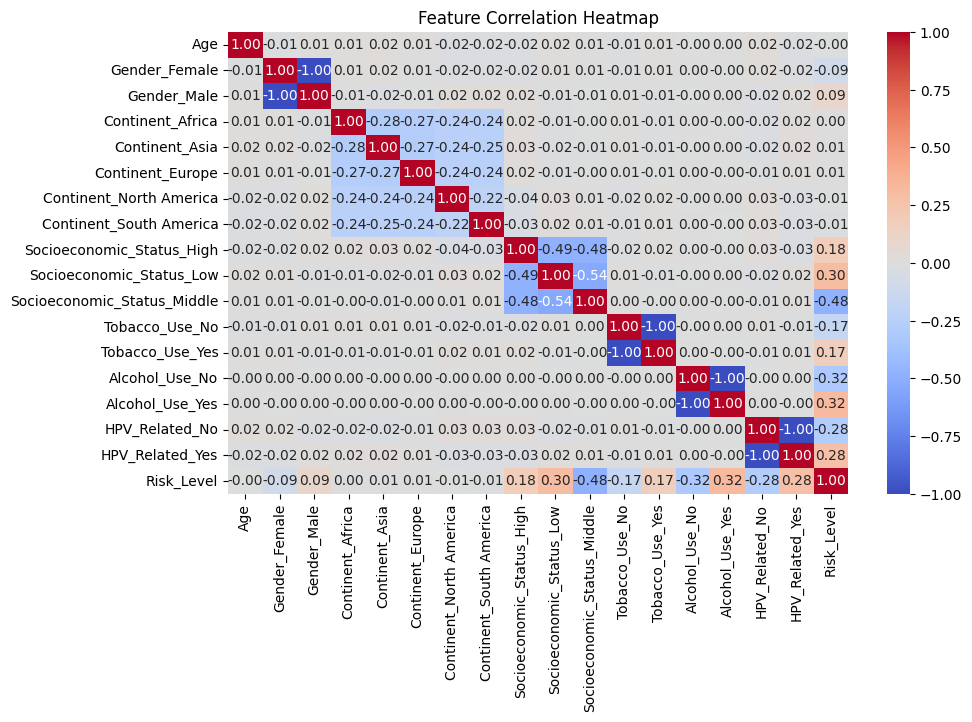

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Check correlation
data['Risk_Level'] = y  # Append target variable to dataset
corr_matrix = data.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
print(data.duplicated().sum())  # Count duplicate rows
print(data.nunique())  # Unique values per column


0
Age                            70
Gender_Female                   2
Gender_Male                     2
Continent_Africa                2
Continent_Asia                  2
Continent_Europe                2
Continent_North America         2
Continent_South America         2
Socioeconomic_Status_High       2
Socioeconomic_Status_Low        2
Socioeconomic_Status_Middle     2
Tobacco_Use_No                  2
Tobacco_Use_Yes                 2
Alcohol_Use_No                  2
Alcohol_Use_Yes                 2
HPV_Related_No                  2
HPV_Related_Yes                 2
Risk_Level                      3
dtype: int64


In [ ]:
print(f"Number of Samples: {X.shape[0]}")
print(f"Number of Features: {X.shape[1]}")


Number of Samples: 15325
Number of Features: 17


In [ ]:
print(data.T.duplicated().sum())  # Check for duplicate columns


0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 🚀 Step 2: Define Cross-Validation (on X_train only)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 🚀 Step 3: Train Model using Cross-Validation
model = RandomForestClassifier(random_state=42)

cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')

# 🚀 Step 4: Print Cross-Validation Results
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

Cross-Validation Accuracy Scores: [1. 1. 1. 1. 1.]
Mean Accuracy: 1.0


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=10)  # Keep top 10 features
X_new = selector.fit_transform(X, y)

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)

cv_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

print(f"Cross-validation accuracies: {cv_scores}")
print(f"Mean accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard deviation: {np.std(cv_scores):.4f}")


Cross-validation accuracies: [1. 1. 1. 1. 1.]
Mean accuracy: 1.0000
Standard deviation: 0.0000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160292 entries, 0 to 160291
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Age                          160292 non-null  float64
 1   Gender_Female                160292 non-null  bool   
 2   Gender_Male                  160292 non-null  bool   
 3   Continent_Africa             160292 non-null  bool   
 4   Continent_Asia               160292 non-null  bool   
 5   Continent_Europe             160292 non-null  bool   
 6   Continent_North America      160292 non-null  bool   
 7   Continent_South America      160292 non-null  bool   
 8   Socioeconomic_Status_High    160292 non-null  bool   
 9   Socioeconomic_Status_Low     160292 non-null  bool   
 10  Socioeconomic_Status_Middle  160292 non-null  bool   
 11  Tobacco_Use_No               160292 non-null  bool   
 12  Tobacco_Use_Yes              160292 non-null  bool   
 13 

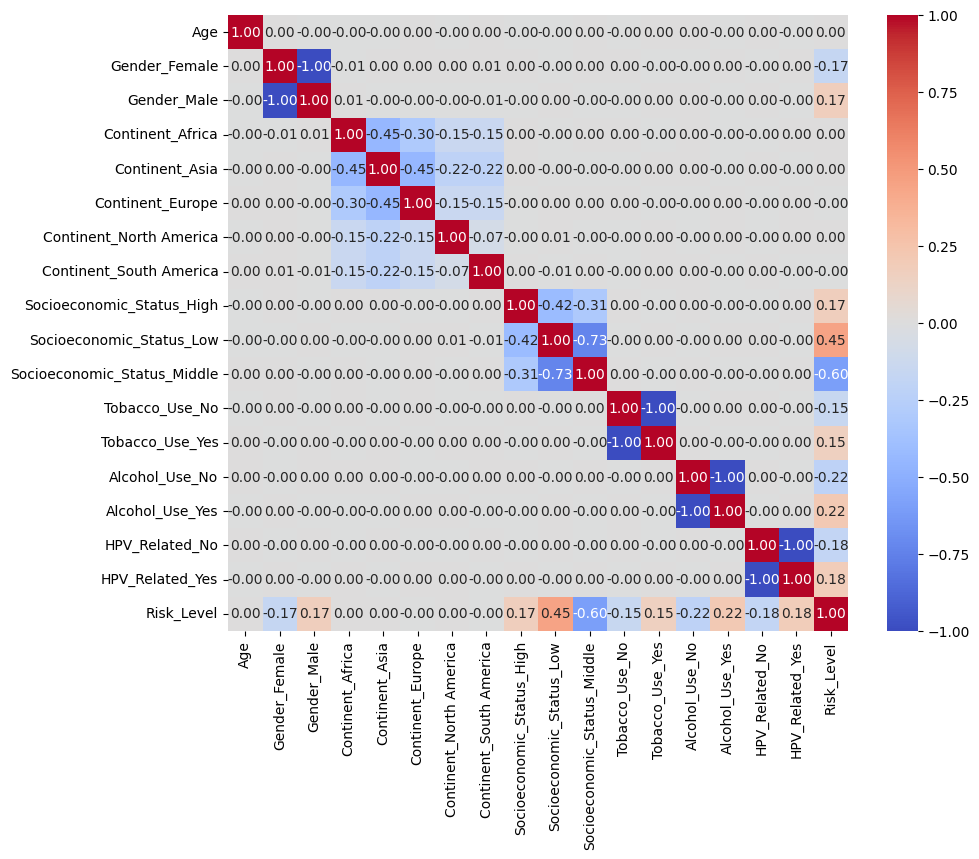

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()


In [ ]:
# Find highly similar columns
duplicate_features = data.T.duplicated()
print("Duplicate Features:\n", data.columns[duplicate_features])

Duplicate Features:
 Index([], dtype='object')


In [ ]:
# Display target value coumts
print(y.value_counts())

Risk_Level
2    61912
1    50191
0    48189
Name: count, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Train the Random Fores**t

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize Random Forest with default parameters
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predictions
rf_train_pred = rf.predict(X_train)
rf_test_pred = rf.predict(X_test)

# Classification Report
print("\n🔹 Random Forest - Training Classification Report:\n", classification_report(y_train, rf_train_pred))
print("\n🔹 Random Forest - Testing Classification Report:\n", classification_report(y_test, rf_test_pred))


🔹 Random Forest - Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     38551
           1       1.00      1.00      1.00     40153
           2       1.00      1.00      1.00     49529

    accuracy                           1.00    128233
   macro avg       1.00      1.00      1.00    128233
weighted avg       1.00      1.00      1.00    128233


🔹 Random Forest - Testing Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9638
           1       1.00      1.00      1.00     10038
           2       1.00      1.00      1.00     12383

    accuracy                           1.00     32059
   macro avg       1.00      1.00      1.00     32059
weighted avg       1.00      1.00      1.00     32059



In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
# Train XGBoost Classifier
xgb_model = xgb.XGBClassifier(objective="multi:softmax", num_class=3, eval_metric="mlogloss", use_label_encoder=False)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:46:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4813
           1       1.00      1.00      1.00      3421
           2       1.00      1.00      1.00      4697

    accuracy                           1.00     12931
   macro avg       1.00      1.00      1.00     12931
weighted avg       1.00      1.00      1.00     12931



In [ ]:
from sklearn.svm import SVC

# Train SVM Classifier
svm_model = SVC(kernel="rbf", C=1.0, gamma="scale")  # Using RBF kernel for better non-linearity handling
svm_model.fit(X_train, y_train)

# Predictions
y_pred_svm = svm_model.predict(X_test)

# Evaluate Model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm:.4f}")
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4813
           1       1.00      1.00      1.00      3421
           2       1.00      1.00      1.00      4697

    accuracy                           1.00     12931
   macro avg       1.00      1.00      1.00     12931
weighted avg       1.00      1.00      1.00     12931



In [ ]:
# Train Logistic Regression Model
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predictions
log_reg_train_pred = log_reg.predict(X_train)
log_reg_test_pred = log_reg.predict(X_test)

# Classification Report
print("\n🔹 Logistic Regression - Training Classification Report:\n", classification_report(y_train, log_reg_train_pred))
print("\n🔹 Logistic Regression - Testing Classification Report:\n", classification_report(y_test, log_reg_test_pred))


🔹 Logistic Regression - Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19250
           1       1.00      1.00      1.00     13684
           2       1.00      1.00      1.00     18788

    accuracy                           1.00     51722
   macro avg       1.00      1.00      1.00     51722
weighted avg       1.00      1.00      1.00     51722


🔹 Logistic Regression - Testing Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4813
           1       1.00      1.00      1.00      3421
           2       1.00      1.00      1.00      4697

    accuracy                           1.00     12931
   macro avg       1.00      1.00      1.00     12931
weighted avg       1.00      1.00      1.00     12931



In [ ]:
# Train Support Vector Machine Model
from sklearn.svm import SVC

svm = SVC(random_state=42)
svm.fit(X_train, y_train)

# Predictions
svm_train_pred = svm.predict(X_train)
svm_test_pred = svm.predict(X_test)

# Classification Report
print("\n🔹 SVM - Training Classification Report:\n", classification_report(y_train, svm_train_pred))
print("\n🔹 SVM - Testing Classification Report:\n", classification_report(y_test, svm_test_pred))


🔹 SVM - Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19250
           1       1.00      1.00      1.00     13684
           2       1.00      1.00      1.00     18788

    accuracy                           1.00     51722
   macro avg       1.00      1.00      1.00     51722
weighted avg       1.00      1.00      1.00     51722


🔹 SVM - Testing Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4813
           1       1.00      1.00      1.00      3421
           2       1.00      1.00      1.00      4697

    accuracy                           1.00     12931
   macro avg       1.00      1.00      1.00     12931
weighted avg       1.00      1.00      1.00     12931



In [ ]:
# Train XGBoost Model
!pip install xgboost # Install the xgboost library
from xgboost import XGBClassifier # import the XGBClassifier

xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train)

# Predictions
xgb_train_pred = xgb.predict(X_train)
xgb_test_pred = xgb.predict(X_test)

# Classification Report
print("\n🔹 XGBoost - Training Classification Report:\n", classification_report(y_train, xgb_train_pred))
print("\n🔹 XGBoost - Testing Classification Report:\n", classification_report(y_test, xgb_test_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:49:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔹 XGBoost - Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19250
           1       1.00      1.00      1.00     13684
           2       1.00      1.00      1.00     18788

    accuracy                           1.00     51722
   macro avg       1.00      1.00      1.00     51722
weighted avg       1.00      1.00      1.00     51722


🔹 XGBoost - Testing Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4813
           1       1.00      1.00      1.00      3421
           2       1.00      1.00      1.00      4697

    accuracy                           1.00     12931
   macro avg       1.00      1.00      1.00     12931
weighted avg       1.00      1.00      1.00     12931



In [ ]:
# Train LightGBM Model
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
lgbm.fit(X_train, y_train)

# Predictions
lgbm_train_pred = lgbm.predict(X_train)
lgbm_test_pred = lgbm.predict(X_test)

# Classification Report
print("\n🔹 LightGBM - Training Classification Report:\n", classification_report(y_train, lgbm_train_pred))
print("\n🔹 LightGBM - Testing Classification Report:\n", classification_report(y_test, lgbm_test_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 51722, number of used features: 17
[LightGBM] [Info] Start training from score -0.988372
[LightGBM] [Info] Start training from score -1.329656
[LightGBM] [Info] Start training from score -1.012665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

**Train Nueral Network Model**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Ensure X_train and X_test are NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

# Encode labels to be in range [0, 2]
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=15)
y_test = to_categorical(y_test, num_classes=15)

# Define Neural Network Model
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(8, activation='relu'),
    Dense(15, activation='softmax')  # 3 clusters
])

# Compile Model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

# Predictions
nn_train_pred = np.argmax(model.predict(X_train), axis=1)
nn_test_pred = np.argmax(model.predict(X_test), axis=1)

# Decode predictions back to original labels
nn_train_pred = le.inverse_transform(nn_train_pred)
nn_test_pred = le.inverse_transform(nn_test_pred)

# Decode true labels
y_train_original = le.inverse_transform(np.argmax(y_train, axis=1))
y_test_original = le.inverse_transform(np.argmax(y_test, axis=1))

# Classification Report
print("\n🔹 Neural Network - Training Classification Report:\n", classification_report(y_train_original, nn_train_pred))
print("\n🔹 Neural Network - Testing Classification Report:\n", classification_report(y_test_original, nn_test_pred))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Invalid dtype: object

In [ ]:
import numpy as np
import joblib

# Load the trained models and scaler
scaler = joblib.load("scaler.pkl")  # Ensure you save the scaler earlier
rf_model = joblib.load("rf_cluster_model.pkl")
xgb_model = joblib.load("xgb_cluster_model.pkl")
lgbm_model = joblib.load("lgbm_cluster_model.pkl")

# 🔹 Correct Label Mapping (Ensure this matches your dataset encoding)
gender_map = {"male": 1, "female": 0}  # Matches label encoding
tobacco_map = {"yes": 1, "no": 0}
alcohol_map = {"yes": 1, "no": 0}
hpv_map = {"yes": 1, "no": 0}
socio_map = {"high": 0, "low": 1, "middle": 2}  # Matches label encoding
continent_map = {"africa": 0, "asia": 1, "europe": 2, "north america": 3, "south america": 4}  # Matches label encoding

# Function to get user input and predict cluster
def get_user_input():
    print("\n🔹 Enter patient details below (type as instructed):\n")

    gender = input("Gender (Male/Female): ").strip().lower()
    age = int(input("Age (Enter a number): ").strip())
    tobacco = input("Tobacco Use? (Yes/No): ").strip().lower()
    alcohol = input("Alcohol Use? (Yes/No): ").strip().lower()
    socioeconomic = input("Socioeconomic Status (Low/Middle/High): ").strip().lower()
    hpv = input("HPV Related? (Yes/No): ").strip().lower()
    continent = input("Continent (Africa/Asia/Europe/North America/South America): ").strip().lower()

    # Convert text to numerical values
    try:
        user_data = [
            gender_map[gender],
            age,
            tobacco_map[tobacco],
            alcohol_map[alcohol],
            socio_map[socioeconomic],
            hpv_map[hpv],
            continent_map[continent]  # Added Continent
        ]
    except KeyError:
        print("\n⚠️ Invalid input! Please type correctly as instructed.\n")
        return None

    return user_data

# Predict function
def predict_user_cluster():
    user_data = get_user_input()
    if user_data is None:
        return

    # Standardize the input
    user_scaled = scaler.transform([user_data])

    # Predict using trained models
    rf_pred = rf_model.predict(user_scaled)[0]
    xgb_pred = xgb_model.predict(user_scaled)[0]
    lgbm_pred = lgbm_model.predict(user_scaled)[0]

    print("\n🔹 Predicted Clusters:")
    print(f"  Random Forest: Cluster {rf_pred}")
    print(f"  XGBoost: Cluster {xgb_pred}")
    print(f"  LightGBM: Cluster {lgbm_pred}")

# Run the prediction for user input
predict_user_cluster()